In [49]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.animation as animation
import glob, re, os
import pandas as pd

#import tensorflow as tf
import seaborn as sns

#from tensorflow import keras
#from tensorflow.keras import layers
# Don't use cuda with keras
#keras.backend.clear_session()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

In [39]:
def plot_loss(history, ax):
    """ Plot the loss function. """
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.grid(True)

In [40]:
dataset_path_dir = "../../build/DATASET_COMPLEX_SPAD/"
list_of_files = glob.glob(dataset_path_dir + "*.csv")
latest_file = max(list_of_files, key=os.path.getctime)
dataset_path = latest_file
print("Dataset path: ", dataset_path)
df = pd.read_csv(dataset_path, sep=",", header=0)

idx_BV = df.columns.get_loc("BreakdownVoltage")
idxBrP = idx_BV + 1
idxDW = idx_BV + 2
idxDoping = np.arange(1, idx_BV, 1)
print(idxDoping)

Dataset path:  ../../build/DATASET_COMPLEX_SPAD/dataset_complex_2023-03-10_22-24-15.csv
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200]


In [41]:
# Drop NaN values
df.dropna()
# The columns in idxDoping must be log10 transformed and the sign kept
df.iloc[:, idxDoping] =np.log10(df.iloc[:, idxDoping])

df.tail()

,TotalLength,Donor_0,Donor_1,Donor_2,Donor_3,Donor_4,Donor_5,Donor_6,Donor_7,Donor_8,...,Acceptors_93,Acceptors_94,Acceptors_95,Acceptors_96,Acceptors_97,Acceptors_98,Acceptors_99,BreakdownVoltage,BreakdownProbability,DepletionWidth
999995,6.0,19.792882,19.792882,19.792882,19.792882,19.792882,19.792882,19.792882,19.792882,19.792882,...,18.221675,18.256237,18.288473,18.318481,18.346353,18.372728,18.397419,17.683,0.619,0.511
999996,6.0,16.565257,16.565257,16.565257,16.565257,16.565257,16.565257,16.565257,16.565257,16.565257,...,18.685114,18.703033,18.719331,18.733598,18.746011,18.756332,18.764624,26.757,0.547,1.008
999997,6.0,16.143951,16.143951,16.143951,16.143951,16.143951,16.143951,16.143951,16.143951,16.143951,...,15.990871,16.016197,16.041787,16.065953,16.088490,16.109916,16.129368,30.480,0.667,0.947
999998,6.0,18.523746,18.523746,18.523746,18.523746,18.523746,18.523746,18.523746,18.523746,18.523746,...,18.612784,18.604982,18.596927,18.590173,18.584444,18.580012,18.576572,15.356,0.718,0.376
999999,6.0,19.555578,19.555578,19.555578,19.555578,19.555578,19.555578,19.555578,19.555578,19.555578,...,17.076640,17.103462,17.128399,17.151063,17.172019,17.190892,17.207904,11.866,0.636,0.271


## Neural network regression to learn BV from Total Length, Donor Length, Donor Level and Acceptor level.

In [42]:
# Neural network regression to learn BV from Total Length, Donor Length, Donor Level and Acceptor level.
# We will use the keras/TensorFlow library to build the neural network.

In [43]:
# Split the data into train and test sets
train_dataset = df.sample(frac=0.5, random_state=0)
test_dataset = df.drop(train_dataset.index)


/home/hellebor/my_utox/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


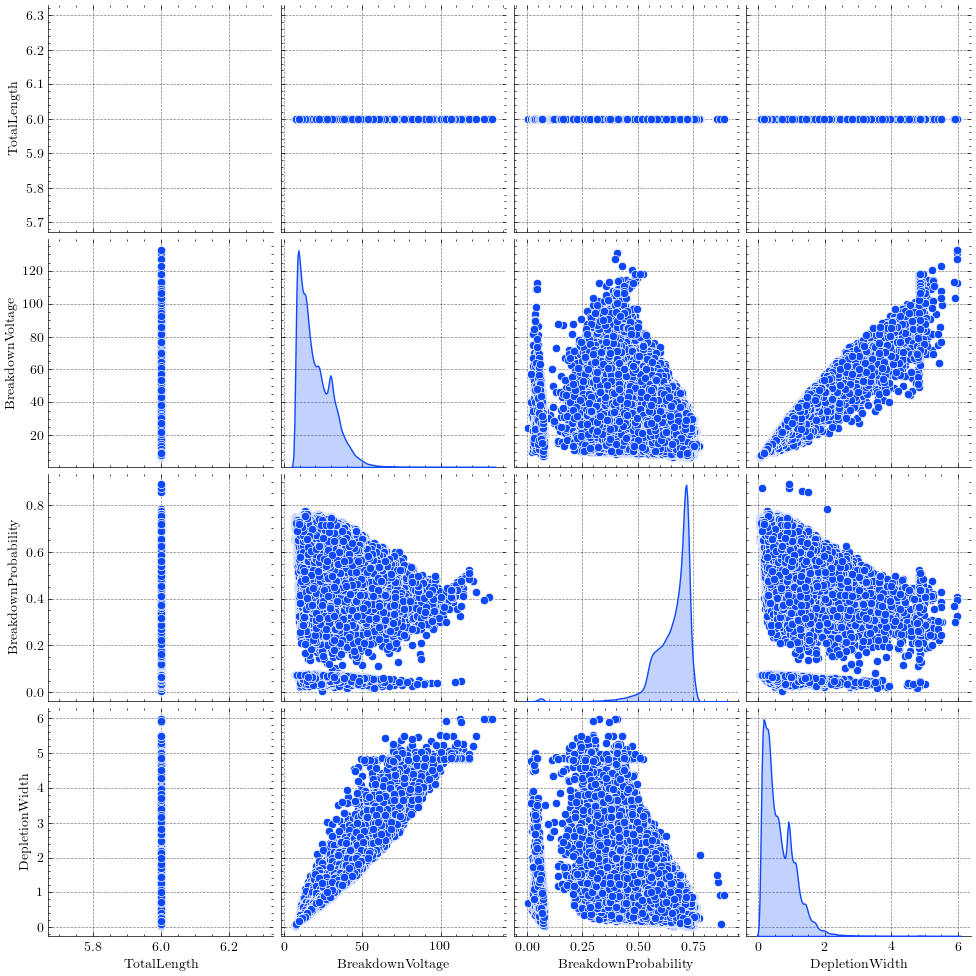

In [44]:
# Inspect the data
pp = sns.pairplot(train_dataset[["TotalLength", "BreakdownVoltage", "BreakdownProbability", "DepletionWidth"]], diag_kind="kde")
plt.show()

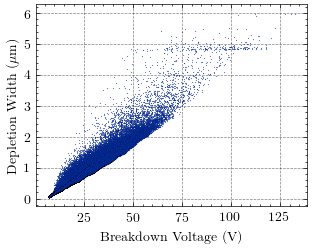

In [45]:
fig, axs = plt.subplots(1, 1)
axs.scatter(train_dataset["BreakdownVoltage"], train_dataset["DepletionWidth"], s=2, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
axs.set_xlabel("Breakdown Voltage (V)")
axs.set_ylabel("Depletion Width ($\mu$m)")
fig.savefig("BreakdownVoltage_vs_DepletionWidth_MC_Sampling.png", dpi=300)
fig.savefig("BreakdownVoltage_vs_DepletionWidth_MC_Sampling.pdf", dpi=300)
plt.show()

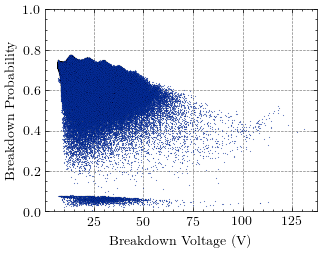

In [46]:
fig, axs = plt.subplots(1, 1)
axs.scatter(train_dataset["BreakdownVoltage"], train_dataset["BreakdownProbability"], s=2, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
axs.set_xlabel("Breakdown Voltage (V)")
axs.set_ylabel("Breakdown Probability")
axs.set_ylim(0, 1)
fig.savefig("BreakdownVoltage_vs_BreakdownProbability_MC_Sampling.png", dpi=300)
fig.savefig("BreakdownVoltage_vs_BreakdownProbability_MC_Sampling.pdf", dpi=300)

plt.show()

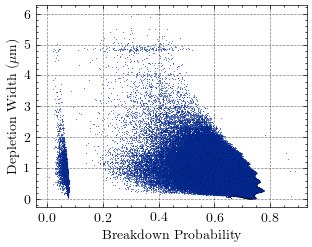

In [47]:
fig, axs = plt.subplots(1, 1)
axs.scatter(train_dataset["BreakdownProbability"], train_dataset["DepletionWidth"], s=2, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
axs.set_xlabel("Breakdown Probability")
axs.set_ylabel("Depletion Width ($\mu$m)")
fig.savefig("BreakdownProbability_vs_DepletionWidth_MC_Sampling.png", dpi=300)
fig.savefig("BreakdownProbability_vs_DepletionWidth_MC_Sampling.pdf", dpi=300)
plt.show()

In [48]:
# 3D plot
%matplotlib qt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
N=1000
X = train_dataset["BreakdownVoltage"][:N:]
Y = train_dataset["DepletionWidth"][:N:]
Z = train_dataset["BreakdownProbability"][:N:]
ax.scatter(X, Z, Y, s=5, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
ax.set_xlabel("BV (V)")
ax.set_ylabel("DW ($\mu$m)")
ax.set_zlabel("BrP")
plt.show()

Frame 359 / 360

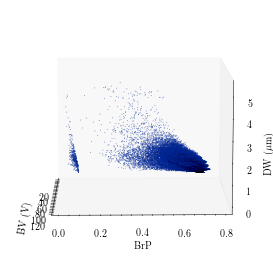

In [37]:
%matplotlib inline
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

N=100000
X = train_dataset["BreakdownVoltage"][:N:]
Y = train_dataset["DepletionWidth"][:N:]
Z = train_dataset["BreakdownProbability"][:N:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("BV (V)")
ax.set_zlabel("DW ($\mu$m)")
ax.set_ylabel("BrP")
ax.grid(False)

scat = ax.scatter(X, Z, Y,  s=2, marker='.', alpha=0.65, edgecolors='k', linewidths=0.1)
fig.tight_layout()

def init():
    ax.view_init(elev=10., azim=0)
    return [scat]


def animate(i):
    print(f"\rFrame {i} / 360", end='', flush=True)
    ax.view_init(elev=10., azim=i)
    return [scat]

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)

# Save
anim.save('/home/hellebor/basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

In [ ]:
train_dataset.describe().transpose()

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

Labels_Features = ["BreakdownVoltage", "BreakdownProbability", "DepletionWidth"]

train_labels = train_features.pop(Labels_Features[0])
test_labels = test_features.pop(Labels_Features[0])

train_labels = train_features.pop(Labels_Features[1])
test_labels = test_features.pop(Labels_Features[1])

train_labels = train_features.pop(Labels_Features[2])
test_labels = test_features.pop(Labels_Features[2])

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


In [ ]:
# First try with a simple linear model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

linear_model.predict(train_features[:10])
linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels_BV,
    epochs=200,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

fig, ax = plt.subplots()
plot_loss(history, ax)
ax.set_ylim(bottom=0.0)

plt.show()

In [ ]:
# Regression with a deep neural network (Input size is 201)
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(2048, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'), 
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model



dnn_model_BV = build_and_compile_model(normalizer)
dnn_model_BV.summary()

history_BV = dnn_model_BV.fit(
    train_features, train_labels_BV,
    validation_split=0.2,
    verbose=1, epochs=250)


In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_BV, ax)
ax.set_ylim(bottom=-2.0)
# Inset zoom
# axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
# plot_loss(history_BV, axins)
# axins.set_xlim(history_BV.epoch[-1]-50, history_BV.epoch[-1])
# axins.set_ylim(0.0, 2.0)
# ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [BV]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Make predictions
test_predictions_BV = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_BV, test_predictions_BV, s=1)
ax.set_xlabel('True Values [BV]')
ax.set_ylabel('Predictions [BV]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_BV)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()

In [ ]:
history_BrP = dnn_model.fit(
    train_features, train_labels_BrP,
    validation_split=0.2,
    verbose=1, epochs=250)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_BrP, ax)
ax.set_ylim(bottom=-0.10, top=2.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_BrP, axins)
axins.set_xlim(history_BrP.epoch[-1]-50, history_BrP.epoch[-1])
axins.set_ylim(0.0, 0.10)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [BrP]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Make predictions
test_predictions_BrP = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_BrP, test_predictions_BrP, s=1)
ax.set_xlabel('True Values [BrP]')
ax.set_ylabel('Predictions [BrP]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_BrP)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()

In [ ]:
history_DW = dnn_model.fit(
    train_features, train_labels_DW,
    validation_split=0.2,
    verbose=1, epochs=250)


In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_DW, ax)
ax.set_ylim(bottom=-0.10, top=1.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_DW, axins)
axins.set_xlim(history_DW.epoch[-1]-50, history_DW.epoch[-1])
axins.set_ylim(0.0, 0.1)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [DW]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Make predictions
test_predictions_DW = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_DW, test_predictions_DW, s=1)
ax.set_xlabel('True Values [DW]')
ax.set_ylabel('Predictions [DW]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_DW)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()
